# Cirrus correction of Landsat 8 imagery

In this guide I will show you how to perform a cloud correction of your Landasat 8 multispectral imagery using the method proposed by [Meng Xu](https://ieeexplore.ieee.org/author/37085428151), [Xiuping Jia](https://ieeexplore.ieee.org/author/37085427273) and [Mark Pickering](https://ieeexplore.ieee.org/author/37062814100) published in the [2014 IEEE Geoscience and Remote Sensing Symposium](https://ieeexplore.ieee.org/xpl/conhome/6919813/proceeding):

**M. Xu, X. Jia and M. Pickering, "Automatic cloud removal for Landsat 8 OLI images using cirrus band," 2014 IEEE Geoscience and Remote Sensing Symposium, Quebec City, QC, 2014, pp. 2511-2514, doi: [10.1109/IGARSS.2014.6946983](https://ieeexplore.ieee.org/document/6946983).**


## Base formal de la corrección

El efecto de las nubes cirrus en las imágenes se puede modelar de acuerdo a la

\begin{equation*}
    y_i(u,v) = x_i^0(u,v) + x_i^c(u,v) \quad   i = 1,2 \dots 7,
\end{equation*}

donde, $y_i(u,v)$ es el nivel digital (ND) almacenado por el sensor OLI para la banda $i$ con $i$=1,2 …7, para el píxel ubicado en $(u,v)$. $x_i^0(u,v)$ es el verdadero ND asociado a la cobertura terrestre y $x_i^c(u,v)$ es la contribución de la nube cirrus en función de su densidad. Con la corrección se busca recuperar $x_i^0(u,v)$.

Con base en los estudios de, y las observaciones de los autores, se plantea que $x_i^c(u,v)$ tiene una relación lineal con el ND $c(u,v)$ la banda cirrus.

\begin{equation*}
    x_i^c(u,v) = \alpha * [c\left(u,v\right) - min \left(c(u,v)\right)]
\end{equation*}
Con lo que finalmente la corrección de cada banda se realiza mediante la:

\begin{equation*}
\displaystyle
   x_i^0(u,v) =  y_i(u,v) - \alpha * [c\left(u,v\right) - min \left(c(u,v)\right)]
\end{equation*}

De esta forma el  reto para poder conocer $x_i^0(u,v)$ es encontrar el factor de corrección $\alpha$ para cada una de las bandas.

## Métodos para hallar $\alpha$

Los autores proponen dos métodos para hallar el factor de corrección $\alpha$: método manual y método automático.

### Método manual
1. Identificación manual de áreas homogéneas en las bandas de la imagen. Ej. Identificación de cuerpos de agua clara.
2. Regresión lineal para hallar los coeficientes $\alpha$ de cada banda.


El método manual demanda un esfuerzo significativo para hallar zonas homogéneas, extraer valores y realizar la regresión lineal, por lo que no fue implementado.

### Método automático


Este método se implementó en el aplicativo mediante 3 etapas: (i) determinación de tamaño de la ventana; (ii) recorrido y cálculo de regresión lineal entre cada banda y la banda Cirrus; (iii) filtrado de los $R^2$ mayores al umbral definido por el usuario y determinación de $\alpha$ a partir de ellos, \autoref{fig:metodo}. $\alpha$  se toma como el valor de la pendiente de la regresión con mayor $R^2$.


El método no requiere de la creación de máscaras ya que la corrección depende de los valores de la banda cirrus. En la banda cirrus las zonas sin presencia de nubes cirrus corresponden a los ND más bajos de la banda por lo que $c(u,v) - min(c(u,v)) = 0$ luego, $x_i^0(u,v) =  y_i(u,v)$, es decir, que en las zonas sin presencia de nubes cirrus no se realiza corrección \autoref{fig:correcion}.



<img src="Images/L8_RGB.png" />

In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np
import cv2
import math
import time
from osgeo import gdal
from skimage import img_as_ubyte
import scipy
import pandas as pd
from sklearn.linear_model import LinearRegression
import statistics

The first step is to load image bands:

In [2]:
images_dir =x = [os.path.join(r,file) for r,d,f in os.walk("Bands/Subset") for file in f]
print("Image bands in directory: ", len(images_dir), '\n')
main_path = images_dir[0][:-6]
#print(main_path)
band_ids =['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']

band_stack = []
pancr = []
cirrus =[]

band_list = []
for band in band_ids:
    if band != 'B8' and band != 'B9':
        full_path = main_path + band + '.tif'
        ds = gdal.Open(full_path)
        band_stack.append(ds.GetRasterBand(1).ReadAsArray())
    elif band == 'B9':
        full_path = main_path + band + '.tif'
        ds = gdal.Open(full_path)
        cirrus.append(ds.GetRasterBand(1).ReadAsArray())
        srs = ds.GetProjectionRef()
        GeoTransform = ds.GetGeoTransform()
                            
        x_size = ds.RasterXSize
        y_size = ds.RasterYSize
        
        
print("Multispectral bands found: ", len(band_stack), '\n')
print("Cirrus found: ", len(cirrus), '\n')
print("Reference system: \n", srs, '\n')
print("Transform: \n", GeoTransform, '\n')

Image bands in directory:  8 

Multispectral bands found:  7 

Cirrus found:  1 

Reference system: 
 PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]] 

Transform: 
 (438540.0, 30.0, 0.0, 1200570.0, 0.0, -30.0) 



Now we can plot the bands:

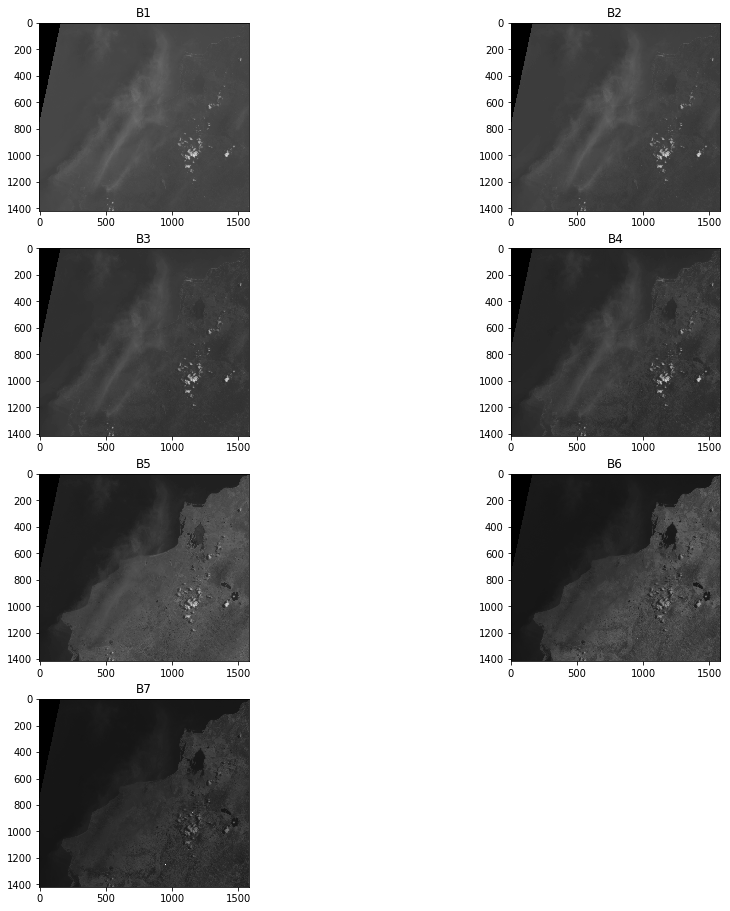

In [12]:
plt.figure(1)
plt.subplots_adjust(left=0.0, right=2.0, bottom=0.0, top=3.0)
subp_idx = 421
for band, band_name in zip(band_stack, band_ids[:7]):
    plt.subplot(subp_idx) ,plt.imshow(band, cmap='gray'),plt.title(band_name)
    subp_idx += 1
plt.show()

The Cirrus band from Landsat 8 is plotted below:

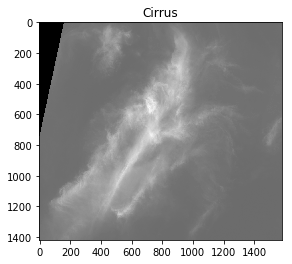

In [6]:
plt.figure(2)
plt.imshow(cirrus[0], cmap='gray'),plt.title('Cirrus')
plt.show()

Now we will define a window:

In [15]:
# Define the window size
windowsize_r = 50
windowsize_c = 50

print(cirrus[0].shape[0] - windowsize_r, cirrus[0].shape[1] - windowsize_c)
print((cirrus[0].shape[0] - windowsize_r)/windowsize_r, (cirrus[0].shape[1] - windowsize_c)/windowsize_c)


1368 1529
27.36 30.58


In [14]:
def dehaze(Band,Cirrus):
    R_square =[]
    coeffs = []
    
    for r in range(0,Band.shape[0] - windowsize_r, windowsize_r):
        for c in range(0,Band.shape[1] - windowsize_c, windowsize_c):
            window1 = Band[r:r+windowsize_r,c:c+windowsize_c]
            window2 = Cirrus[r:r+windowsize_r,c:c+windowsize_c]
            X =window1.ravel()
            #print("X: ", X)
            Y = window2.ravel()
            #print("Y: ", Y)
            if min(X) >0 and min(Y) >0:
                model = LinearRegression().fit(X.reshape((-1, 1)), Y.reshape((-1, 1)))
                r_sq = model.score(X.reshape((-1, 1)), Y.reshape((-1, 1)))
                #print('coefficient of determination:', r_sq)
                #print('intercept:', model.intercept_)
                #print('slope:', model.coef_)
                if r_sq > 0.9:
                    R_square.append(r_sq)
                    coeffs.append(model.coef_)
                    
    out = np.concatenate(coeffs).ravel()
    coeff = max(out)
    min_cirrus = np.ndarray.min(Cirrus[np.nonzero(Cirrus)])
    
    # 0 to NaN
    Band_nan = Band.astype(np.float32)
    Cirrus_nan = Cirrus.astype(np.float32)
    
    Band_nan[Band_nan == 0] = np.nan
    Cirrus_nan[Cirrus_nan == 0] = np.nan
    
    Cor_Band = Band_nan - coeff * (Cirrus_nan - min_cirrus)
    return Cor_Band, coeff

In [9]:
Adj_bands = []
for band, band_name in zip(band_stack,band_ids[:7]):
    Cor_Band, coeff = dehaze(band,cirrus[0])
    Adj_bands.append(Cor_Band)
    print("Correction coefficient for ", band_name, ' is: ', coeff, '\n')
    
    file_output = main_path + 'DH_' +band_name + '.tif'
    print('Guardando banda: ' + file_output + '\n')
                    
    driver = gdal.GetDriverByName('GTiff')
    arch = driver.Create(file_output,x_size,y_size,1,gdal.GDT_UInt16)
    #arch = driver.Create(file_output,x_size,y_size,1,gdal.GDT_Float32)
    arch.SetGeoTransform(GeoTransform)
    arch.SetProjection(srs)
    arch.GetRasterBand(1).WriteArray(Cor_Band.astype(np.uint16))
    #arch.GetRasterBand(1).WriteArray(self.BANDA_CORR.astype(np.float32))
    del(arch)

Correction coefficient for  B1  is:  0.948821213840654 

Guardando banda: Bands/Subset/L8_L1TP_0953_20200430_DH_B1.tif

Correction coefficient for  B2  is:  0.9410943874297968 

Guardando banda: Bands/Subset/L8_L1TP_0953_20200430_DH_B2.tif

Correction coefficient for  B3  is:  1.063660007188137 

Guardando banda: Bands/Subset/L8_L1TP_0953_20200430_DH_B3.tif

Correction coefficient for  B4  is:  0.9352481301302594 

Guardando banda: Bands/Subset/L8_L1TP_0953_20200430_DH_B4.tif

Correction coefficient for  B5  is:  0.7656494268082819 

Guardando banda: Bands/Subset/L8_L1TP_0953_20200430_DH_B5.tif

Correction coefficient for  B6  is:  1.5702943090099126 

Guardando banda: Bands/Subset/L8_L1TP_0953_20200430_DH_B6.tif

Correction coefficient for  B7  is:  1.5337940466128137 

Guardando banda: Bands/Subset/L8_L1TP_0953_20200430_DH_B7.tif



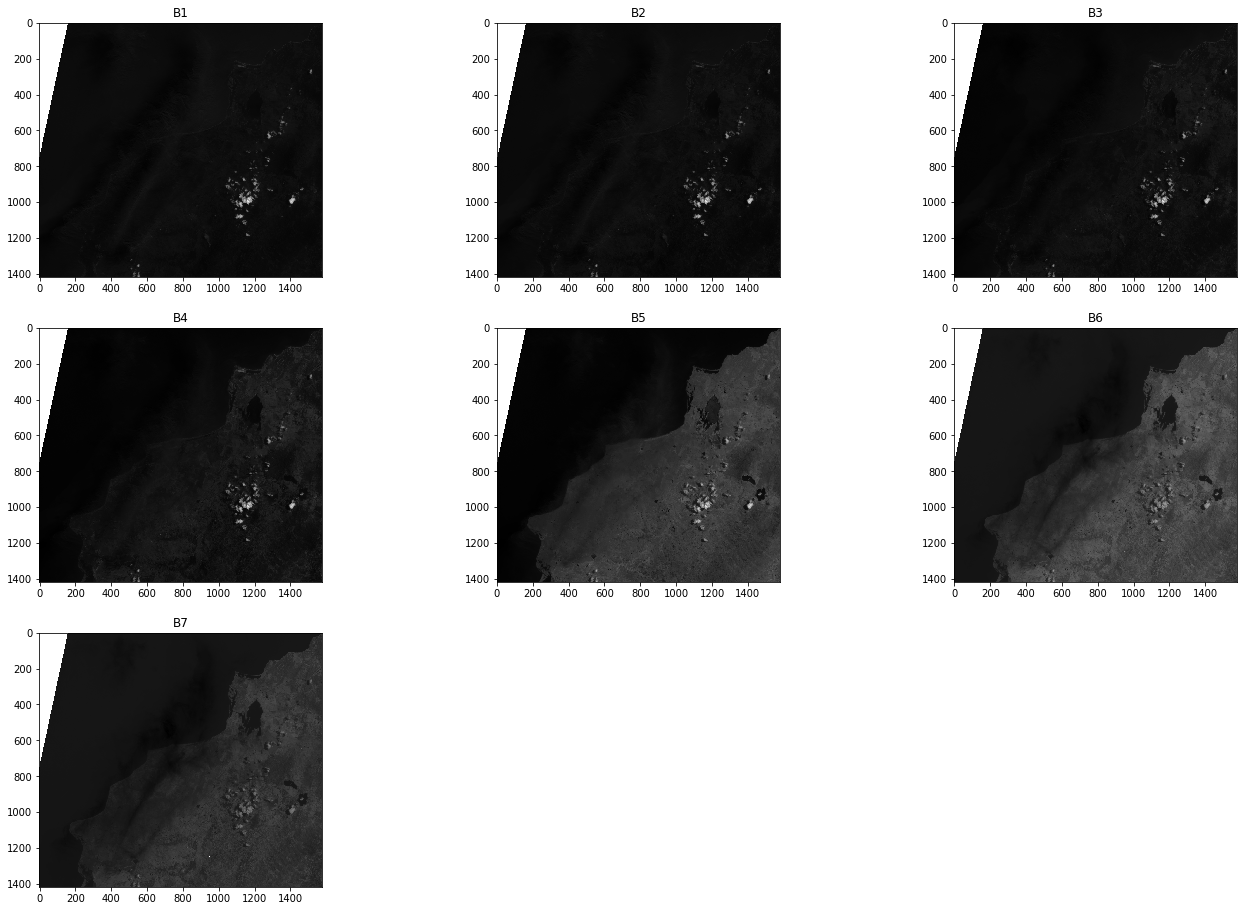

In [10]:
plt.figure(3)
plt.subplots_adjust(left=0.0, right=3.0, bottom=0.0, top=3.0)
subp_idx = 331
for band, band_name in zip(Adj_bands, band_ids[:7]):
    plt.subplot(subp_idx) ,plt.imshow(band, cmap='gray'),plt.title(band_name)
    subp_idx += 1
plt.show()